# Dokumentacja wstępna 

## Filtr wykrywający krawędzie w wideo, w czasie rzeczywistym.

Funkcjonalność projektu:

- Poprawnie negocjuje parametry transmisji interfejsem HDMI.
- Odbiera strumień wideo z innego urządzenia.
- Wykonuje operacje wykrywania krawędzi w odebranym obrazie.
- Nanosi wykryte krawędzie na obraz wyjściowy.
- Nadaje strumień wideo na wyjście HDMI.

Projekt wykonywany na sprzęcie własnym. Na płytce [Nexys Video] z układem FPGA Xilinx Artix-7 XC7A200T-1SBG484C. Płytka jest wyposażona w potrzebne złącza wejście  HDMI i wyjście HDMI.

[Nexys Video]: https://reference.digilentinc.com/reference/programmable-logic/nexys-video/reference-manual?fbclid=IwAR33quUNPj1-sevbe4yfgbg7NtRSuu5IIi0UPC7HwtIQmubVyf3x_IuBAcM

## Analiza techniczna elementów systemu

### Interfejsy:

- wejście HDMI
- wyjście HDMI

### Algorytmy:

Algorytm Canny'ego do detekcji krawędzi dzieli się na pięć części.

- Konwersja na biało-czarne
- Redukcja szumu
- Obliczenie gradientu
- Tłumienie
- Podwójny próg
- Śledzenie krawędzi przez histerezę

#### Konwersja na biało-czarne

Algorytm detekcji krawędzi działa na opbrazach biało-czarnych dlatego na początek wyznaczając średnią ze wszystkich kolorów zmieniamy obraz w białoczarny.

In [893]:
import numpy as np
import math
import cv2
import scipy.signal
from matplotlib import pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 5]

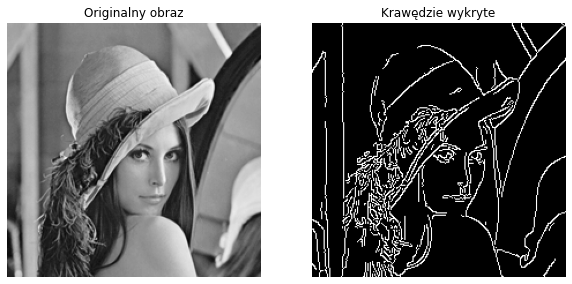

In [894]:
img = cv2.imread('lena.png',0)
plt.subplot(121), plt.imshow(img, cmap = 'gray')
plt.title('Originalny obraz'), plt.axis('off');

edges = cv2.Canny(img, 100,200)
plt.subplot(122), plt.imshow(edges,cmap = 'gray')
plt.title("Krawędzie wykryte"), plt.axis('off'), plt.show();

#### Redukcja szumu

Polega na rozmyciu obrazu w celu zminimalizowania wpływu szumu na wynik działania algorytmu. Najczęściej stosuje się rozmycie gaussowskie. Polega ono na splocie obrazu z odpowiedzią filtru utworzoną na podstawie rozkładu normalnego.

In [895]:
def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g

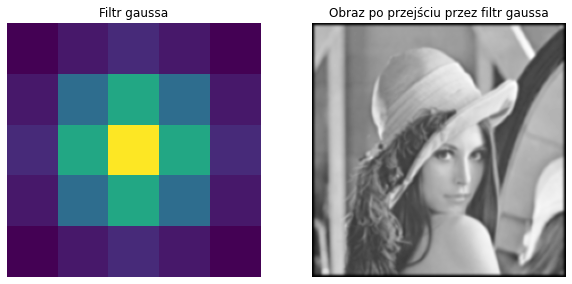

In [896]:
plt.subplot(121), plt.imshow(gaussian_kernel(5)), plt.axis('off')
plt.title('Filtr gaussa')
plt.subplot(122), plt.imshow(scipy.signal.convolve2d(img,gaussian_kernel(5)), cmap='gray')
plt.title('Obraz po przejściu przez filtr gaussa'), plt.axis('off'), plt.show();

#### Obliczanie gradientu

Do obliczenia przybliżenia gradientu można skorzystać z operatora Sobela

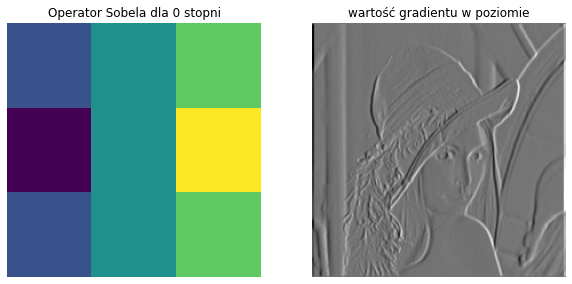

In [897]:
sobelKx = np.array([[-1,0,1],[-2,0,2], [-1,0,1]])
plt.subplot(121), plt.imshow(sobelKx), plt.axis('off'); plt.title('Operator Sobela dla 0 stopni')

Ix = scipy.signal.convolve2d(img,sobelKx)
plt.subplot(122), plt.imshow(Ix, cmap='gray'), plt.axis('off'), plt.title('wartość gradientu w poziomie')
plt.show();

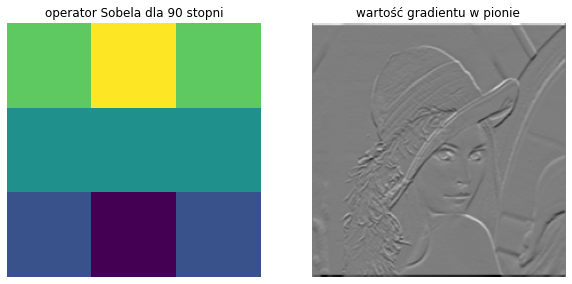

In [898]:
sobelKy = np.array([[1,2,1],[0,0,0], [-1,-2,-1]])
plt.subplot(121), plt.imshow(sobelKy), plt.axis('off'), plt.title("operator Sobela dla 90 stopni");
Iy = scipy.signal.convolve2d(img,sobelKy)
plt.subplot(122), plt.imshow(Iy, cmap='gray'), plt.axis('off'), plt.title('wartość gradientu w pionie'), plt.show();

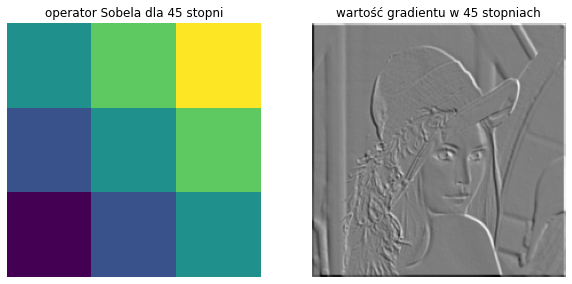

In [899]:
sobelKz = np.array([[0,1,2],[-1,0,1], [-2,-1,0]])
plt.subplot(121), plt.imshow(sobelKz), plt.axis('off'), plt.title("operator Sobela dla 45 stopni");
Iz = scipy.signal.convolve2d(img,sobelKz)
plt.subplot(122), plt.imshow(Iz, cmap='gray'), plt.axis('off'), plt.title('wartość gradientu w 45 stopniach'), plt.show();

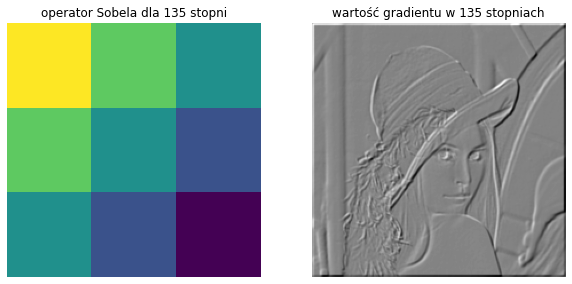

In [900]:
sobelKt = np.array([[2,1,0],[1,0,-1], [0,-1,-2]])
plt.subplot(121), plt.imshow(sobelKt), plt.axis('off'), plt.title("operator Sobela dla 135 stopni");
It = scipy.signal.convolve2d(img,sobelKt)
plt.subplot(122), plt.imshow(It, cmap='gray'), plt.axis('off'), plt.title('wartość gradientu w 135 stopniach'), plt.show();

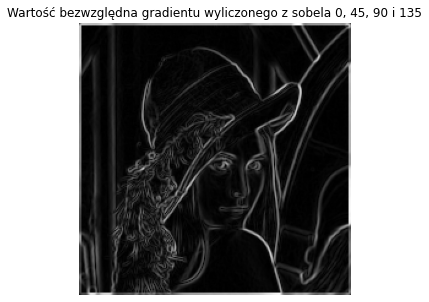

In [901]:
G1 = np.sqrt(Ix**2 + Iy**2 + Iz**2 + It**2)
G1 = G1 / G1.max() * 255
G1 = G1.astype('uint8')
plt.title('Wartość bezwzględna gradientu wyliczonego z sobela 0, 45, 90 i 135'), plt.imshow(G1, cmap='gray'), plt.axis('off'), plt.show();

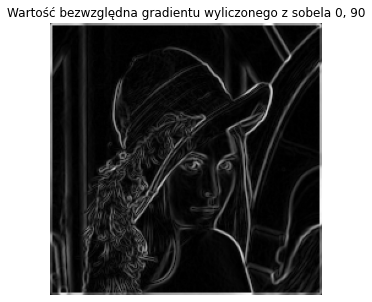

In [902]:
G = np.hypot(Ix, Iy)
G = G / G.max() * 255
G = G.astype('uint8')
plt.title('Wartość bezwzględna gradientu wyliczonego z sobela 0, 90'), plt.imshow(G, cmap='gray'), plt.axis('off'), plt.show();

> Jak widać różnica jest nie wielka. Można więc zrezygnować z 45 i 135 stopni.

In [903]:
theta = np.arctan2(Iy, Ix)

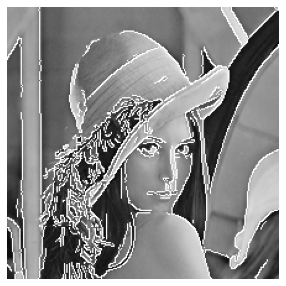

In [904]:
plt.imshow(np.maximum(img,edges), cmap='gray'), plt.axis('off'), plt.show();

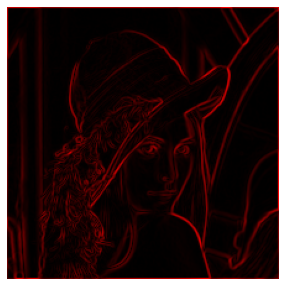

In [905]:
zero = np.zeros((220,220))
color_G = np.stack((G[1:221,1:221],zero , zero), axis=2).astype('uint8')
color_img = np.stack((img,img,img), axis=2)
plt.imshow(color_G), plt.axis('off'), plt.show();

In [906]:
color_G.shape

(220, 220, 3)

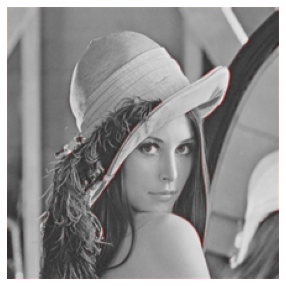

In [907]:
plt.imshow(np.maximum(color_G,color_img)), plt.axis("off"), plt.show();

## Status prac

W powijakach

<p align="right"> Wiktor Szczerek <br> Filip Kulik <br> Jacek Dobrowolski </p>